In [1]:
import numpy as np
import tensorflow as tf
import cv2
import sys
# 绘图
%matplotlib inline
from matplotlib import pyplot as plt
tf.enable_eager_execution()

In [55]:
image = cv2.imread(r'images/origin/faces.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
"""
image = plt.imread("Anthony_Hopkins_0002.jpg")
"""
h, w, _ = image.shape

In [3]:
class PNet(tf.keras.Model):
    def __init__(self):
        super(PNet, self).__init__()
        self.conv1 = conv2d(10, 3, 1, 'valid', name='conv1')
        self.prelu1 = tf.keras.layers.PReLU(name='prelu1', shared_axes=[1, 2])
        self.pool1 = pool2d(name='pool1')

        self.conv2 = conv2d(16, 3, 1, 'valid', name='conv2')
        self.prelu2 = tf.keras.layers.PReLU(name='prelu2', shared_axes=[1, 2])

        self.conv3 = conv2d(32, 3, 1, 'valid', name='conv3')
        self.prelu3 = tf.keras.layers.PReLU(name='prelu3', shared_axes=[1, 2])

        self.conv4_1 = conv2d(
            2, 1, 1, 'same', activation='softmax', name='conv4_1')
        self.conv4_2 = conv2d(4, 1, 1, 'same', name='conv4_2')

    def call(self, input_):
        out = self.conv1(input_)
        out = self.prelu1(out)
        out = self.pool1(out)
        out = self.conv2(out)
        out = self.prelu2(out)
        out = self.conv3(out)
        out = self.prelu3(out)

        prob = self.conv4_1(out)
        loc = self.conv4_2(out)
        return prob, loc

    def model_variable_initialize(self):
        image = tf.random_normal((1, 12, 12, 3))
        with tf.name_scope('PNet'):
            self.call(image)
        print("P Completed")


class RNet(tf.keras.Model):
    def __init__(self):
        super(RNet, self).__init__()
        self.conv1 = conv2d(28, 3, 1, 'valid', name='conv1')
        self.prelu1 = tf.keras.layers.PReLU(name='prelu1', shared_axes=[1, 2])
        self.pool1 = pool2d(3, 2, name='pool1')

        self.conv2 = conv2d(48, 3, 1, 'valid', name='conv2')
        self.prelu2 = tf.keras.layers.PReLU(name='prelu2', shared_axes=[1, 2])
        self.pool2 = pool2d(3, 2, 'valid', name='pool2')

        self.conv3 = conv2d(64, 2, 1, 'valid', name='conv3')
        self.prelu3 = tf.keras.layers.PReLU(name='prelu3', shared_axes=[1, 2])

        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(128, name='fc1')
        self.prelu4 = tf.keras.layers.PReLU(name='prelu4')

        self.fc2_1 = tf.keras.layers.Dense(
            2, activation='softmax', name='fc2_1')
        self.fc2_2 = tf.keras.layers.Dense(4, name='fc2_2')

    def call(self, input_):
        out = self.conv1(input_)
        out = self.prelu1(out)
        out = self.pool1(out)
        out = self.conv2(out)
        out = self.prelu2(out)
        out = self.pool2(out)
        out = self.conv3(out)
        out = self.prelu3(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.prelu4(out)

        prob = self.fc2_1(out)
        loc = self.fc2_2(out)
        return prob, loc

    def model_variable_initialize(self):
        image = tf.random_normal((1, 24, 24, 3))
        with tf.name_scope('RNet'):
            self.call(image)
        print("R Completed")


class ONet(tf.keras.Model):
    def __init__(self):
        super(ONet, self).__init__()
        self.conv1 = conv2d(32, 3, 1, 'valid', name='conv1')
        self.prelu1 = tf.keras.layers.PReLU(name='prelu1', shared_axes=[1, 2])
        self.pool1 = pool2d(3, 2, name='pool1')

        self.conv2 = conv2d(64, 3, 1, 'valid', name='conv2')
        self.prelu2 = tf.keras.layers.PReLU(name='prelu2', shared_axes=[1, 2])
        self.pool2 = pool2d(3, 2, 'valid', name='pool2')

        self.conv3 = conv2d(64, 3, 1, 'valid', name='conv3')
        self.prelu3 = tf.keras.layers.PReLU(name='prelu3', shared_axes=[1, 2])
        self.pool3 = pool2d(2, 2, name='pool3')

        self.conv4 = conv2d(128, 2, 1, 'valid', name='conv4')
        self.prelu4 = tf.keras.layers.PReLU(name='prelu4', shared_axes=[1, 2])

        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(256, name='fc1')
        self.prelu5 = tf.keras.layers.PReLU(name='prelu5')

        self.fc2_1 = tf.keras.layers.Dense(
            2, activation='softmax', name='fc2_1')
        self.fc2_2 = tf.keras.layers.Dense(4, name='fc2_2')
        self.fc2_3 = tf.keras.layers.Dense(10, name='fc2_3')

    def call(self, input_):
        out = self.conv1(input_)
        out = self.prelu1(out)
        out = self.pool1(out)
        out = self.conv2(out)
        out = self.prelu2(out)
        out = self.pool2(out)
        out = self.conv3(out)
        out = self.prelu3(out)
        out = self.pool3(out)
        out = self.conv4(out)
        out = self.prelu4(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.prelu5(out)

        prob = self.fc2_1(out)
        loc = self.fc2_2(out)
        landmark = self.fc2_3(out)
        return prob, loc, landmark

    def model_variable_initialize(self):
        image = tf.random_normal((1, 48, 48, 3))
        with tf.name_scope('ONet'):
            self.call(image)
        print("O Completed")


def conv2d(filter, ksize=3, stride=1, padding='same', dilation=1, activation=None, name="conv2d"):
    ksize = [ksize] * 2
    strides = [stride] * 2
    dilation = [dilation] * 2
    return tf.keras.layers.Conv2D(filters=filter, kernel_size=ksize, strides=strides, padding=padding, dilation_rate=dilation, activation=activation, name=name)


def pool2d(ksize=2, stride=2, padding='same', name='pool2d'):
    ksize = [ksize] * 2
    strides = [stride]*2
    return tf.keras.layers.MaxPool2D(pool_size=ksize, strides=strides, padding=padding, name=name)



In [4]:
P = PNet()
R = RNet()
O = ONet()
P.model_variable_initialize()
R.model_variable_initialize()
O.model_variable_initialize()

Instructions for updating:
Colocations handled automatically by placer.
P Completed
R Completed
O Completed


In [5]:
P.load_weights("./checkpoints/pnet/model")
R.load_weights("./checkpoints/rnet/model")
O.load_weights("./checkpoints/onet/model")

In [56]:
########################################################################
# Note: first stage for PNet.
########################################################################
images, scales = generate_samples_from_image(image, 30)
total_bboxes = []
total_bboxes_ref = []
for img, scale in zip(images, scales):
    prob, loc = P(np.transpose(img,(0,2,1,3)))
    prob = tf.transpose(prob,(0,2,1,3))
    loc = tf.transpose(loc,(0,2,1,3))
    original_bboxes = generate_original_boxes(loc.numpy(), scale)
    filter_mask = tf.argmax(prob, axis=-1)
    bboxes_tf = tf.boolean_mask(original_bboxes, filter_mask)
    bboxes_ref_tf = tf.boolean_mask(loc, filter_mask)
    local_bboxes, local_bboxes_ref = bboxes_nms(
        bboxes_tf.numpy(), bboxes_ref_tf.numpy(), 0.5)
    total_bboxes.append(local_bboxes)
    total_bboxes_ref.append(local_bboxes_ref)
total_bboxes = np.concatenate(total_bboxes)
total_bboxes_ref = np.concatenate(total_bboxes_ref)
bboxes, bboxes_ref = bboxes_nms(total_bboxes, total_bboxes_ref, 0.7)
bboxes = bboxes_reg(bboxes, bboxes_ref)
bboxes = rec2square(bboxes.copy())
bboxes_pnet, pad_bboxes = bboxes_clip(bboxes, w, h)
images = crop_image(image, bboxes_pnet, pad_bboxes)

In [57]:
images.shape

(56, 24, 24, 3)

In [58]:
rnet_prob, rnet_loc = R(np.transpose(images,(0,2,1,3)))
scores = rnet_prob[:, 1]
filter_mask_rnet = scores > 0.7
bboxes_ref_rnet_tf = tf.boolean_mask(rnet_loc, filter_mask_rnet)
bboxes_rnet_tf = tf.boolean_mask(bboxes_pnet, filter_mask_rnet)
bboxes_rnet = bboxes_select(
    bboxes_rnet_tf.numpy(), bboxes_ref_rnet_tf.numpy(), 0.7)
bboxes_rnet, pad_bboxes_rnet = bboxes_clip(bboxes_rnet, w, h)
images = crop_image(image, bboxes_rnet, pad_bboxes_rnet, [48, 48])

In [59]:
images.shape

(2, 48, 48, 3)

In [60]:
onet_prob, onet_loc, onet_landmark = O(np.transpose(images,(0,2,1,3)))
scores = onet_prob[:, 1]
filter_mask_onet = scores > 0.7
bboxes_ref_onet_tf = tf.boolean_mask(onet_loc, filter_mask_onet)
bboxes_onet_tf = tf.boolean_mask(bboxes_rnet, filter_mask_onet)

bboxes_onet = bboxes_select(
    bboxes_onet_tf.numpy(), bboxes_ref_onet_tf.numpy(), 0.7,'min')
bboxes_onet, pad_bboxes_onet = bboxes_clip(bboxes_onet, w, h)

In [61]:
bboxes_onet

array([[ 23,  78,  48, 102],
       [148,  79, 173, 104]])

In [33]:
np.max(scores.numpy())

0.9991359

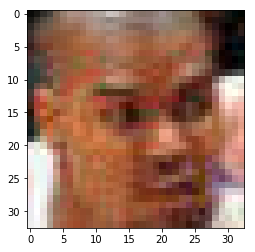

In [54]:
x1,y1,x2,y2 = [156,  42, 189,  75]
temp = image[y1:y2,x1:x2]
plt.imshow(temp)

In [ ]:
image = cv2.imread(r'‪C:\Users\Mashiro\Desktop\m.png',cv2.CV_LOAD_IMAGE_UNCHANGED)
#plt.imshow(image)
image.shape

In [ ]:
a = temp.copy()
a[:,:,0] = temp[:,:,2]
a[:,:,2] = temp[:,:,0]
cv2.imwrite('face_02.jpg',a)

In [17]:
plt.imsave('face_03.jpg',temp)

In [ ]:
class Detect(object):
    def __init__(self, pnet, rnet, onet):
        self.P = pnet
        self.R = rnet
        self.O = onet

    def detect_face(self, image, minsize=30):
        h, w, _ = image.shape
        images, scales = generate_samples_from_image(image, minsize)
        ########################################################################
        # Note: first stage for PNet.
        ########################################################################
        total_bboxes = []
        total_bboxes_ref = []
        for img, scale in zip(images, scales):
            pnet_prob, pnet_loc = self.P(np.transpose(img, (0, 2, 1, 3)))
            pnet_prob = tf.transpose(pnet_prob, (0, 2, 1, 3))
            pnet_loc = tf.transpose(pnet_loc, (0, 2, 1, 3))
            original_bboxes = generate_original_boxes(pnet_loc.numpy(), scale)
            filter_mask = tf.argmax(pnet_prob, axis=-1)
            bboxes_tf = tf.boolean_mask(original_bboxes, filter_mask)
            bboxes_ref_tf = tf.boolean_mask(pnet_loc, filter_mask)
            local_bboxes, local_bboxes_ref = bboxes_nms(
                bboxes_tf.numpy(), bboxes_ref_tf.numpy(), 0.6)
            total_bboxes.append(local_bboxes)
            total_bboxes_ref.append(local_bboxes_ref)
        total_bboxes = np.concatenate(total_bboxes)
        total_bboxes_ref = np.concatenate(total_bboxes_ref)
        bboxes_pnet = bboxes_select(total_bboxes, total_bboxes_ref, 0.7)
        if bboxes_pnet.shape[0] == 0:
            return None
        bboxes_pnet, pad_bboxes_pnet = bboxes_clip(bboxes_pnet, w, h)
        images = crop_image(image, bboxes_pnet, pad_bboxes_pnet)
        ########################################################################
        # Note: second stage for RNet.
        ########################################################################
        rnet_prob, rnet_loc = self.R(np.transpose(images, (0, 2, 1, 3)))
        scores = rnet_prob[:, 1]
        filter_mask_rnet = scores > 0.7
        bboxes_ref_rnet_tf = tf.boolean_mask(rnet_loc, filter_mask_rnet)
        bboxes_rnet_tf = tf.boolean_mask(bboxes_pnet, filter_mask_rnet)
        bboxes_rnet = bboxes_select(
            bboxes_rnet_tf.numpy(), bboxes_ref_rnet_tf.numpy(), 0.7)
        if bboxes_rnet.shape[0] == 0:
            return None
        bboxes_rnet, pad_bboxes_rnet = bboxes_clip(bboxes_rnet, w, h)
        images = crop_image(image, bboxes_rnet, pad_bboxes_rnet, [48, 48])
        ########################################################################
        # Note: third stage for RNet.
        ########################################################################
        onet_prob, onet_loc, onet_landmark = self.O(
            np.transpose(images, (0, 2, 1, 3)))
        scores = onet_prob[:, 1]
        filter_mask_onet = scores > 0.7
        bboxes_ref_onet_tf = tf.boolean_mask(onet_loc, filter_mask_onet)
        bboxes_onet_tf = tf.boolean_mask(bboxes_rnet, filter_mask_onet)
        bboxes_onet = bboxes_select(
            bboxes_onet_tf.numpy(), bboxes_ref_onet_tf.numpy(), 0.7)
        if bboxes_onet.shape[0] == 0:
            return None
        bboxes_onet, pad_bboxes_onet = bboxes_clip(bboxes_onet, w, h)
        return bboxes_onet


In [ ]:
detect = Detect(P,R,O)

In [ ]:
loc = detect.detect_face(image)

In [ ]:
loc

In [ ]:
for v in P.variables:
    print(v.name)

In [ ]:
cv2.__version__

In [6]:
def resize_image(image, size=(12, 12)):
    return cv2.resize(image, size)


def preprocess_image(image):
    """Preprocess a image"""
    image_cp = np.copy(image).astype(np.float32)
    # regularize the image
    image_regular = (image_cp-127.5)/128
    # expand the batch_size dim
    image_expanded = np.expand_dims(image_regular, axis=0)
    return image_expanded


def cal_scales(minsize, factor=0.709, size=(12, 12)):
    minlen = np.min(size)
    s = 12.0/minsize
    minlen *= (s*factor)
    scales = [s]
    while (minlen >= 12):
        scales.append(s * np.power(factor, len(scales)))
        minlen *= factor
    return scales


def generate_samples_from_image(image, minsize=20, factor=0.709):
    height, weight, _ = image.shape
    scales = cal_scales(minsize, factor, size=(weight, height))
    images = []
    for scale in scales:
        w, h = int(np.ceil(weight * scale)), int(np.ceil(height * scale))
        images.append(preprocess_image(resize_image(image, size=(h, w))))
    return images, scales


def generate_original_boxes(bbox_reg, scale):
    # bboxes shape of (1,h,w,4)
    bboxes = np.zeros_like(bbox_reg, dtype=np.float32)
    _, h, w, _ = np.shape(bboxes)
    y, x = np.mgrid[0:h, 0:w]
    bboxes[0, :, :, 0] = x * 2 / scale
    bboxes[0, :, :, 1] = y * 2 / scale
    bboxes[0, :, :, 2] = (x * 2+12) / scale
    bboxes[0, :, :, 3] = (y * 2+12) / scale
    return tf.convert_to_tensor(bboxes)


def bboxes_iou(bboxes1, bboxes2, method="union"):
    """Computing iou between bboxes1 and bboxes2.
    Note: bboxes1 and bboxes2 can be multi-dimensional, but should broacastable.
    """
    bboxes1 = np.transpose(bboxes1)
    bboxes2 = np.transpose(bboxes2)
    # Intersection bbox and volume.
    int_ymin = np.maximum(bboxes1[0], bboxes2[0])
    int_xmin = np.maximum(bboxes1[1], bboxes2[1])
    int_ymax = np.minimum(bboxes1[2], bboxes2[2])
    int_xmax = np.minimum(bboxes1[3], bboxes2[3])

    int_h = np.maximum(int_ymax - int_ymin, 0.)
    int_w = np.maximum(int_xmax - int_xmin, 0.)
    int_vol = int_h * int_w
    # Union volume.
    vol1 = (bboxes1[2] - bboxes1[0]) * (bboxes1[3] - bboxes1[1])
    vol2 = (bboxes2[2] - bboxes2[0]) * (bboxes2[3] - bboxes2[1])

    if method == "min":
        iou = int_vol / np.minimum(vol1, vol2)
    else:
        iou = int_vol / (vol1 + vol2 - int_vol)
    return iou


def bboxes_nms(bboxes, bboxes_ref, nms_threshold=0.5, method="union"):
    """Apply non-maximum selection to bounding boxes.
    """
    keep_bboxes = np.ones((bboxes.shape[0],), dtype=np.bool)
    for i in range(bboxes.shape[0]-1):
        if keep_bboxes[i]:
            # Computer overlap with bboxes which are following.
            overlap = bboxes_iou(bboxes[i], bboxes[(i+1):], method)
            # Overlap threshold for keeping + checking part of the same class
            keep_overlap = overlap < nms_threshold
            keep_bboxes[(i+1):] = np.logical_and(keep_bboxes[(i+1):],
                                                 keep_overlap)
    idxes = np.where(keep_bboxes)
    return bboxes[idxes], bboxes_ref[idxes]


def bboxes_reg(bboxes, bboxes_ref):
    """boxes bounding regression.

    Args:
        bboxes ([array]): original boxes
        bboxes_ref ([array]): [description]

    Returns:
        [array]: [description]
    """
    bboxes = bboxes.astype(np.float32)
    w = bboxes[:, 2] - bboxes[:, 0] + 1
    h = bboxes[:, 3] - bboxes[:, 1] + 1
    bboxes[:, 0] += bboxes_ref[:, 0] * w
    bboxes[:, 1] += bboxes_ref[:, 1] * h
    bboxes[:, 2] += bboxes_ref[:, 2] * w
    bboxes[:, 3] += bboxes_ref[:, 3] * h
    return bboxes


def rec2square(bboxes):
    """Convert bbox to square."""
    h = bboxes[:, 3]-bboxes[:, 1]
    w = bboxes[:, 2]-bboxes[:, 0]
    l = np.maximum(w, h)
    bboxes[:, 0] = bboxes[:, 0]+w*0.5-l*0.5
    bboxes[:, 1] = bboxes[:, 1]+h*0.5-l*0.5
    bboxes[:, 2:4] = bboxes[:, 0:2] + np.transpose(np.tile(l, (2, 1)))
    return bboxes


def bboxes_clip(bboxes, w, h):
    """Clip bounding boxes

    Args:
        bboxes ([array]): shape of (N, 4)
        w ([int]): the width of input image
        h ([int]): the heigh of input image

    Returns:
        [tuple of array]: return the position of cliped boxes and
        padding for each axis
    """
    bboxes_cp = bboxes.copy()
    boxes_w = (bboxes[:, 2]-bboxes[:, 0]+1).astype(np.int32)
    boxes_h = (bboxes[:, 3] - bboxes[:, 0] + 1).astype(np.int32)
    bboxes_cp[:, 0] = np.maximum(bboxes[:, 0], 0)
    bboxes_cp[:, 1] = np.maximum(bboxes[:, 1], 0)
    bboxes_cp[:, 2] = np.minimum(bboxes[:, 2], w)
    bboxes_cp[:, 3] = np.minimum(bboxes[:, 3], h)

    pad_bboxes = np.zeros_like(bboxes, dtype=np.int32)
    pad_bboxes[:, 0] = bboxes_cp[:, 0] - bboxes[:, 0]
    pad_bboxes[:, 1] = bboxes_cp[:, 1] - bboxes[:, 1]
    pad_bboxes[:, 2] = bboxes[:, 2] - bboxes_cp[:, 2]
    pad_bboxes[:, 3] = bboxes[:, 3] - bboxes_cp[:, 3]
    pad_bboxes[pad_bboxes < 0] = 0
    return bboxes_cp.astype(np.int32), pad_bboxes


def crop_image(image, bboxes, pad_bboxes, size=[24, 24]):
    # example shape of [N,24,24,3]
    shape = [bboxes.shape[0]] + list(size) + [3]
    images = np.zeros(shape, dtype=np.float32)
    for idx in range(bboxes.shape[0]):
        x1, y1, x2, y2 = bboxes[idx]
        padding = ((pad_bboxes[idx, 1], pad_bboxes[idx, 3]),
                   (pad_bboxes[idx, 0], pad_bboxes[idx, 2]),
                   (0, 0))
        temp_img = image[y1:y2, x1:x2, :]
        temp_img = np.pad(
            temp_img, padding, 'constant', constant_values=0)
        images[idx] = resize_image(temp_img, size=tuple(size))
    return (images-127.5)/128


def bboxes_select(bboxes, bboxes_ref, threshold=0.5, method="union"):
    """A series operation for boxes selected.

    Args:
        bboxes ([array]): Original locations for boxes, shape of (N, 4).
        bboxes_ref ([array): Regression locations for boxes, shape of (N, 4).
        threshold (float, optional): Defaults to 0.5.

    Returns:
        [array]: selected boxes.
    """
    bboxes, bboxes_ref = bboxes_nms(
        bboxes, bboxes_ref, threshold, method=method)
    '''
    if bboxes.shape[0] == 0:
        return bboxes
    '''
    bboxes = bboxes_reg(bboxes, bboxes_ref)
    bboxes = rec2square(bboxes.copy())
    return bboxes


In [ ]:
image.dtype